Data Ingest
======

The data is a key component of any machine learning algorithm.
The ingest of the data,
including the cleanup and labelling stages,
is often the most time consuming.
It requires taking the raw data,
in our case Molecular Dyanmics trajectories, and
computing or extracting the quantities which will be used
for the Machine Learning.

In this example we will be using the relative orientations
of neighbouring molecules for our classification.
So by the end of this workbook we will have
a collection of data containing;

- the relative orientations of up to 6 nearest neighbours,
- the known classification, and
- temperature 

The input files
--------------

The input data for this tutorial is in the folder `data`,
which contains a series of `.gsd` files.
This is the default file format of [Hoomd-blue](http://glotzerlab.engin.umich.edu/hoomd-blue/)
a molecular dynamics package designed to run on GPUs
from the Glotzer group at the University of Michigan.

To read these files we are going to use the [gsd](http://gsd.readthedocs.io/en/latest/) package
that the glotzer group provide.
To read files from other simulation packages [MDAnalysis](https://www.mdanalysis.org/)
is a python package that will read nearly any file type.
To read all the files that we want,
we are going to use the [pathlib](https://docs.python.org/3/library/pathlib.html) module 
from python's (>= 3.4) standard library.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sdanalysis.figures import plot_frame
from sdanalysis.order import relative_orientations
import sklearn

import sys
sys.path.append('../src')
from detection import read_all_files, classify_mols, plot_confusion_matrix

from bokeh.plotting import show, output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
input_files = read_all_files(
    '../data/simulations/dataset/output/',
    index=-1
)

### Collate Simulation Data

This code is enough to read all the input files,
so the next step is to actually do something useful
with each of the files.

Within each of the filenames I have included 
the parameters of the simulation.

### Labelling Data

This has given us sufficient information about the simulation,
we now need to work out the classification of each molecule.
The configurations that I have prepared consist of two phases,
the middle 2/3 in the $x$ and $y$ directions is crystalline
while the remainer of the simulation cell is liquid.
This is probably easiest to understand using a picture;

In [3]:
show(plot_frame(input_files[9].snapshot))
print(input_files[4].pressure)

1.00


#### We can define molecules that have an $x$ position in the range
$
-L_x/3 < x < L_x/3
$
and have a $y$ position in the range
$
-L_y/3 < y < L_y/3
$
as being crystalline, with the crystal structure taken from the filename. 
The remaining molecules can be classed as the generic liquid.
As before we can write a simple function
that takes a snapshot and the cyrstal structure,
returning the annotated classification of all molecules in the simulation.
At the interface of the two phases
the classification is not well defined,
so for the purposes of training and testing, 
I am going to remove molecules within a distance of 3.5,
a bit over 1 neighbour shell,
to the boundary.

In [4]:
crystals = [classify_mols(data.snapshot, data.crystal) for data in input_files]

### Compute training features

The final step is to compute the nearest neighbours for each of the molecules.
Most of the work of this function is done
using a function I wrote, `relative_orientations`.
This function uses the the kdtree algorithm from scipy to compute the neighbours efficiently.
A side effect of using this function is that the neighbours are returned in order of increasing distance.
Then computes the relative orientation of the neighbour orientations using quaternion maths.

It should be noted that this the relative orientations function requires the orientations
to be expressed as quaternions. 

The parameters to the relative_orientations function, `max_radius` and `max_neighbours`
are passed to the algorithm computing the neighbour lists.
`max_radius` defines the maximum distance to search for neighbours,
beyond this distance molecules are not considered neighbours.
The `max_neighbours` parameter defines the maximum number of neighbours to find.
Where there are more molecules within the `max_radius` 
only the closest `max_neighbours` are returned.

In [5]:
orientations = [
    relative_orientations(snap.box, snap.position, snap.orientation) 
    for snap, *_ in input_files
]

Loading the Data
----------------

Now with all the parts in place we can load all the data into a pandas DataFrame.
Taking the code we had at the start to read in all the snapshots,
we can now apply the functions we have just written,

- `get_sim_params`,
- `classify_mols`, and
- `compute_orientations`

to process the data into a succinct and usable form.

Finding a Machine Learning Model
=================

There are many different types of models we can use for classification,
each of these models have types of problems they are well suited to.
The goal of this notebook is to identify algorithms 
that will effectively classify our dataset
which we can then investigate further.

### Collating the models

The first step here is creating a list of models we would like to test.
An excellent property of scikit-learn is 
that all the algorithms have the same API,
allowing us to treat them all in the same way. 

This is not an exhastive list of all the possible classifiers in scikit-learn,
just a smattering for comparison.
For a more exhastive list check out [the scikit-learn documentation](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning),
and feel free to add more to the list.

In [6]:
from sklearn import linear_model, discriminant_analysis, tree, neighbors, naive_bayes, svm, neural_network

ml_models = {
    'LR': linear_model.LogisticRegression(),
    'LDA': discriminant_analysis.LinearDiscriminantAnalysis(),
    'DT': tree.DecisionTreeClassifier(),
    'KNN': neighbors.KNeighborsClassifier(),
    'NB': naive_bayes.GaussianNB(),
#     'SVM': svm.SVC(),
#     'NN': neural_network.MLPClassifier()
}

### Loading the training data

We need to load in the training dataset we created in the first notebook.
At this point we are interested in two sets of data,

- $X$, the input data which is the orientation of the six nearest neighbours
- $Y$, the true labelled classification of the data.

In [7]:
y = np.concatenate(crystals)
mask = y < 4
y = y[mask]
X = np.concatenate(orientations)[mask]

### Testing the Models

With a collection of models to test,
we now need some method of testing the models to compare them.
To perform the initial screening of datasets
we are going to break our training data into two groups,

- the training set, comprising 80% of the molecules
- the validation set, comprising the remaining 20%.

This division of the dataset gives us a set of data 
previously unseen by the algorithms,
giving us a method of testing whether
the algorithm is acutally learning the underlying features,
or just 'memorising' the training data.
This division of data will be through a random selection
so as not to bias the selection of data.

In [8]:
validation_size = 0.20
seed = 7

selected = sklearn.model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)
X_train, X_validation, y_train, y_validation = selected

To get an idea of the models which
warrant a further investigation,
we can iterate through each of our models.
Each model is scored by breaking the training data into `n_splits`,
using one of these splits for testing and
the remaining splits for training.
This process is referred to as *cross validation*
and typically the number of splits is 10.
For the purposes of this running in a reasonable amount of time,
`n_splits` is set to 2.

In [9]:
scoring='accuracy'
n_splits = 2
# Typically n_splits would be 10 but it runs much slower
#n_splits = 10

# Iterate through each model in our dictionary of models
for name, model in ml_models.items():
    kfold = sklearn.model_selection.KFold(n_splits=n_splits, random_state=seed)
    cv_results = sklearn.model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    print(f'{name:5s}: {cv_results.mean():.5f} ± {cv_results.std():.5f}')

LR   : 0.54675 ± 0.00100
LDA  : 0.52688 ± 0.00084
DT   : 0.61819 ± 0.00096
KNN  : 0.66617 ± 0.00118
NB   : 0.52504 ± 0.00141


Out of all the algorithms tested, 
there are three that stand out 

- K-Nearest Neighbours (KNN),
- Support Vector Machine (SVM), and
- Neural Network (NN)

with accuracies in excess of 95%. 

So with these three algorithms it is likely worth
tweaking the algorithms slightly from 
the defualt paramters in an effort to improve performance.
It is also worth understanding which classes
each of these algorithms is strongest at classifying.
For this additional data we are going to be using a [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).
In a confusion matrix, 
the diagonal elements represent the correct classifications,
while the off diagonal elements are the values 
which were incorrectly classified.

Below we have a handy function from the scikit-learn documentation
that will nicely plot the confusion matrix as a heatmap. 

It is this point where our breaking the data into
training and validation sets becomes useful.
We can train a classifier using the training set,
then generate predictions of the validation dataset
using the known values of the validation data
to generate the confusion matrix.

Normalized confusion matrix


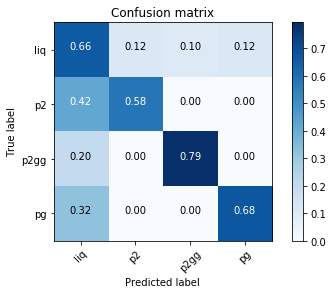

In [10]:
classes = ["liq", "p2", "p2gg", "pg"]
knn = ml_models['KNN']
knn.fit(X_train, y_train)
predictions = knn.predict(X_validation)
plot_confusion_matrix(sklearn.metrics.confusion_matrix(y_validation, predictions, labels=range(4)), classes, normalize=True)

In [11]:
svm = ml_models['SVM']
svm.fit(X_train, y_train)
predictions = svm.predict(X_validation)
plot_confusion_matrix(sklearn.metrics.confusion_matrix(y_validation, predictions, labels=range(4)), classes, normalize=True)

KeyError: 'SVM'

In [ ]:
nn = ml_models['NN']
nn.fit(X_train, y_train)
predictions = nn.predict(X_validation)
plot_confusion_matrix(sklearn.metrics.confusion_matrix(y_validation, predictions, labels=range(4)), classes, normalize=True)

It is interesting to note that all of the models
have the most difficulty with the liquid/crystal characterisation,
with the largest proportion of false positives being 
crystal incorrectly classified as liquid. 
To make this model we have created persistent
it needs to be saved which is done using `joblib`.

In [ ]:
sklearn.externals.joblib.dump(ml_models['KNN'], '../models/knn-trimer.pkl') 

ML in Production
=========

So far we have been looking at building a machine learning model,
while this is nice we actually want to be able to use it
to perform useful science.

This notebook will demonstrate the application of the machine learning algorithm
that we built in the first part of the tutorial to
the classification of a previously unseen configuration.

Loading the Model
----------------

At the end of the [previous notebook](02_Lets_Find_A_Model.ipynb)
we saved the model as a python pickle using scikit-learn's `joblib` library.
This converted the in memory object that represented the trained state
of the machine learning algorithm into a form that could be saved to disk.
By reading the file `knn-model.pkl` from disk,
we can load the trained K-Nearest Neighbours model.

In [ ]:
model = sklearn.externals.joblib.load('../models/knn-trimer.pkl')
model

With the model now loaded we need some data to apply it to.
For this we need to load a configuration and
compute the relative orientation of all the neareset neighbours.
With the nearest neighbour orientations comptued,
all that is left to do is use the model to predict the classes.